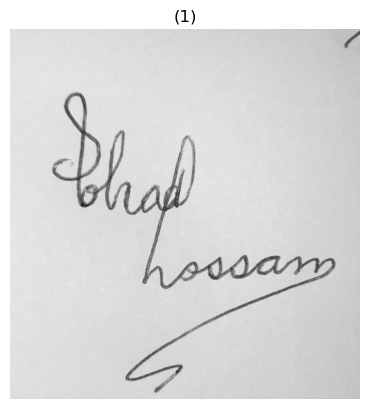

(1280, 1212)


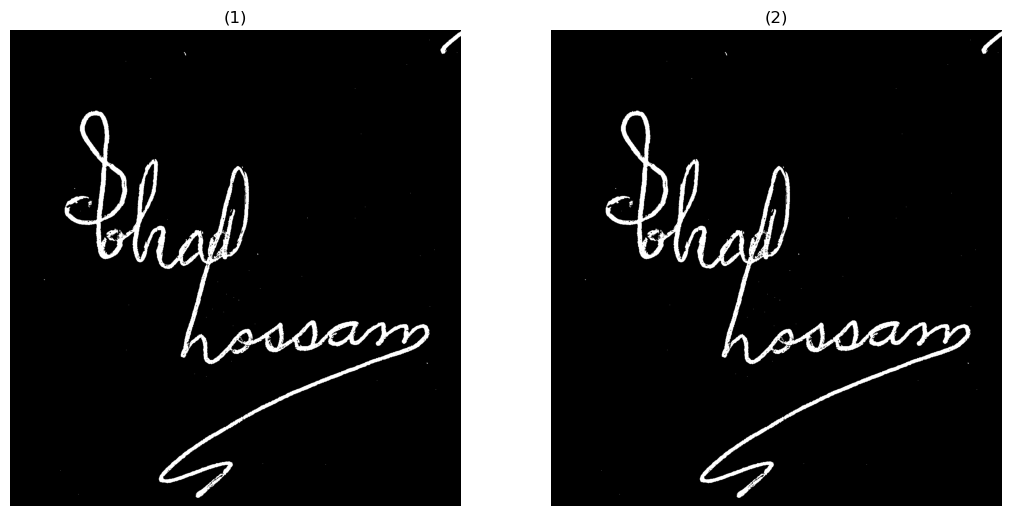

In [5]:
from commonfunctions import  *

def img2gray(image: np.ndarray) -> np.ndarray:
    if len(image.shape) > 3:
        image = image[:, :, 0:3, 0]
    if len(image.shape) == 2:
        return image
    else:
        gray_img = rgb2gray(image)
        return gray_img

def any2rgb(img: np.ndarray) -> np.ndarray:
    # Converts any image to rgb image, returns a copy of the image
    # Args:
    #    image (np.ndarray): image
    # Returns:
    #    np.ndarray: rgb image
    image = img.copy()
    if len(image.shape) > 3:
        image = image[:, :, 0:3, 0]
    if len(image.shape) == 2:
        return gray2rgb(image)
    elif len(image.shape) == 3:
        if image.shape[2] == 3:
            return image
        elif image.shape[2] == 4:
            return rgba2rgb(image)
    else:
        raise Exception("Invalid image shape")

def local_thresholding_segment(image: np.ndarray, block_size: int, offset: float) -> None:
    image = image * 255
    binary_image = np.zeros(image.shape, dtype=bool)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            start_row = max(0, i - block_size // 2)
            end_row = min(image.shape[0], i + block_size // 2 + 1)
            start_col = max(0, j - block_size // 2)
            end_col = min(image.shape[1], j + block_size // 2 + 1)

            local_mean = np.mean(image[start_row:end_row, start_col:end_col])

            local_threshold = local_mean - offset

            binary_image[i, j] = image[i, j] < local_threshold

    return binary_image



def local_thresholding_parallelized(image: np.ndarray, block_size: int, offset: float) -> None:
    r, c = image.shape
    image_sections = [image[0:r//2, 0:c//2],  image[0:r//2, c//2:c], image[r//2:r, 0:c//2], image[r//2:r, c//2:c]]
    
    threads = list()
    sections_list = [0] * len(image_sections) 
    for i in range(len(image_sections)):
        thread = threading.Thread(target=local_thresholding, args=(image_sections[i], block_size, offset, sections_list, i, ))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()
    
    
    image[0:r//2, 0:c//2] = sections_list[0]
    image[0:r//2, c//2:c] = sections_list[1]
    image[r//2:r, 0:c//2] = sections_list[2]
    image[r//2:r, c//2:c] = sections_list[3]
    return image


    

def local_thresholding(image: np.ndarray, block_size: int, offset: float, sections_list: list[np.ndarray], index) -> None:
    segmented_image = local_thresholding_segment(image, block_size, offset)
    
    sections_list[index] = segmented_image
    

image = io.imread('2/forged/1.jpg')
gray_img = img2gray(image)
show_images([gray_img])
print(gray_img.shape)
test = local_thresholding_segment(gray_img, 35, 10)
test_img = local_thresholding_parallelized(gray_img, 35, 10)



show_images([test_img, test])